In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
from PIL import Image
!pip install numpy pandas
import pandas as pd
!pip install roboflow
from roboflow import Roboflow
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random

In [2]:
rf = Roboflow(api_key="s0usIb1HAC6nEWOv2Kse")
project = rf.workspace("ali-rostami").project("labeled-mri-brain-tumor-dataset")
version = project.version(1)
dataset = version.download("multiclass")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Labeled-MRI-Brain-Tumor-Dataset-1 in multiclass:: 100%|██████████| 2451/2451 [00:00<00:00, 6006.78it/s]


In [3]:
# Set data folder
data_folder = "/content/Labeled-MRI-Brain-Tumor-Dataset-1"

CSV File in /content/Labeled-MRI-Brain-Tumor-Dataset-1/train
Shape: (1695, 5)
Columns: Index(['filename', ' Glioma', ' Meningioma', ' No Tumor', ' Pituitary'], dtype='object')
Head of the DataFrame:
                                            filename   Glioma   Meningioma  \
0  Tr-pi_0164_jpg.rf.000776527ec0acdc89e31e15a352...        0            0   
1  Tr-no_0426_jpg.rf.0026b06f369c5d51aca4c4c9beba...        0            0   
2  Tr-gl_0496_jpg.rf.010620fbbbaa509aa81d7ce5bdf7...        1            0   
3  Tr-gl_0554_jpg.rf.010a72c1c25cc9ce83c77fbb23db...        1            0   
4  Tr-me_0185_jpg.rf.0094b0b539582e2f95ae7b6ada4d...        0            1   

    No Tumor   Pituitary  
0          0           1  
1          1           0  
2          0           0  
3          0           0  
4          0           0  


CSV File in /content/Labeled-MRI-Brain-Tumor-Dataset-1/test
Shape: (246, 5)
Columns: Index(['filename', ' Glioma', ' Meningioma', ' No Tumor', ' Pituitary'], dtype='obj

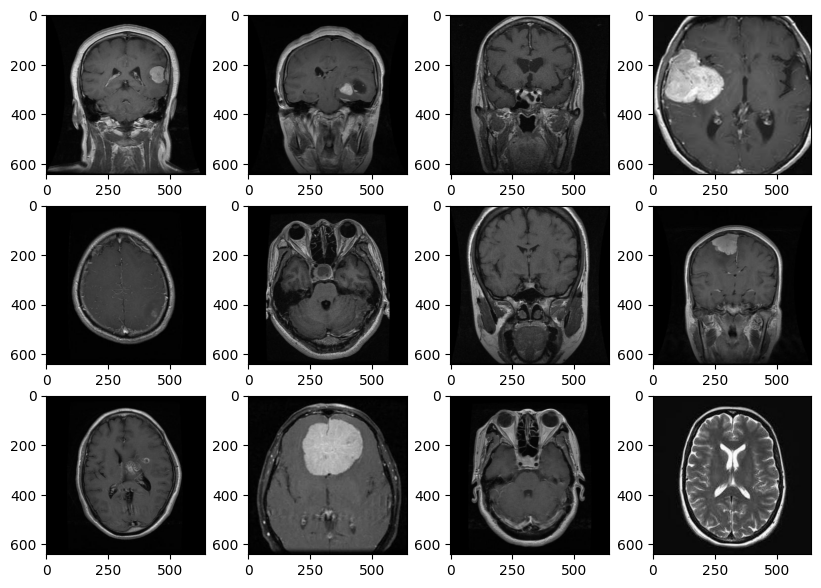

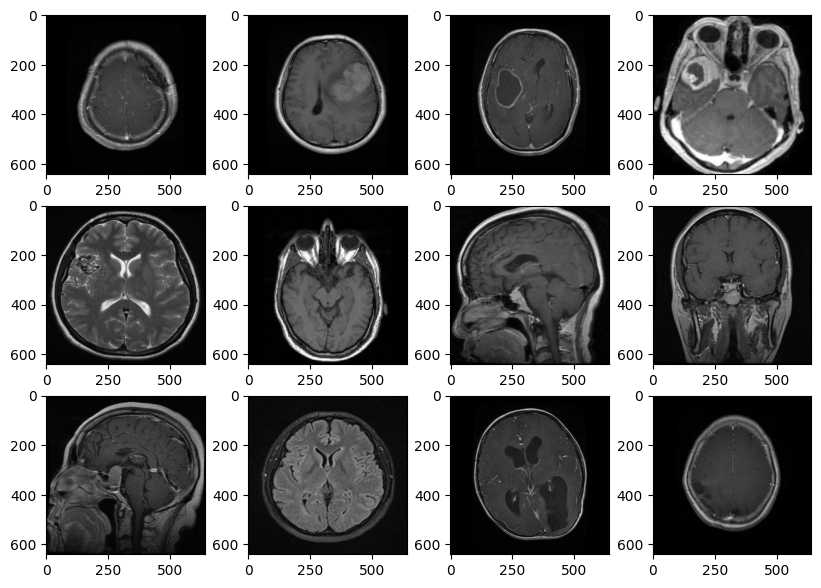

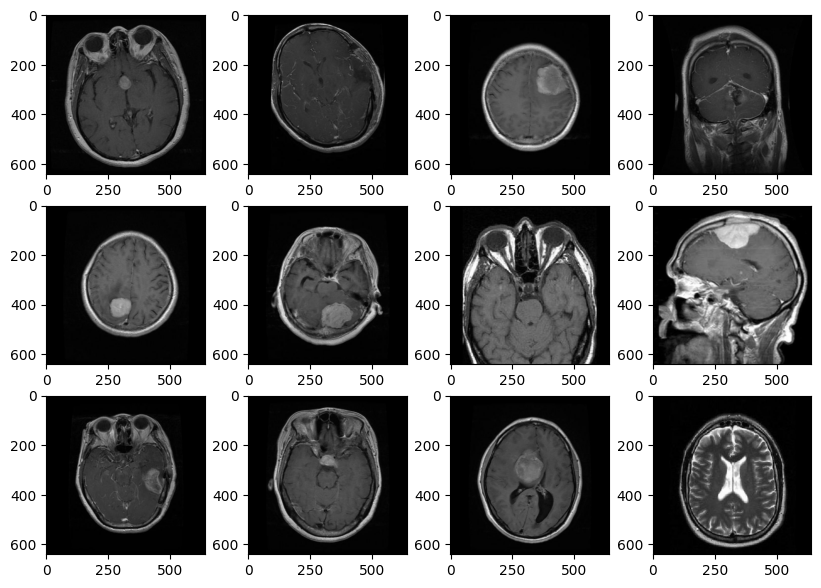

In [4]:
# Set data folders
train_folder = "/content/Labeled-MRI-Brain-Tumor-Dataset-1/train"
test_folder = "/content/Labeled-MRI-Brain-Tumor-Dataset-1/test"
valid_folder = "/content/Labeled-MRI-Brain-Tumor-Dataset-1/valid"
def display_csv_content(folder):
    csv_file = [file for file in os.listdir(folder) if file.endswith('.csv')][0]
    csv_path = os.path.join(folder, csv_file)
    df = pd.read_csv(csv_path)
    print("CSV File in", folder)
    print("Shape:", df.shape)
    print("Columns:", df.columns)
    print("Head of the DataFrame:")
    print(df.head())
    print("\n")

# Display contents of CSV files from train, test, and valid folders
display_csv_content(train_folder)
display_csv_content(test_folder)
display_csv_content(valid_folder)

def display_images(folder):
    fig = plt.figure(figsize=(10, 7))
    images = [file for file in os.listdir(folder) if file.endswith('.jpg')][:12]
    columns = 4
    rows = 3
    for i, image in enumerate(images, 1):
        img_path = os.path.join(folder, image)
        img = Image.open(img_path)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

# Display images from train, test, and valid folders
display_images(train_folder)
display_images(test_folder)
display_images(valid_folder)

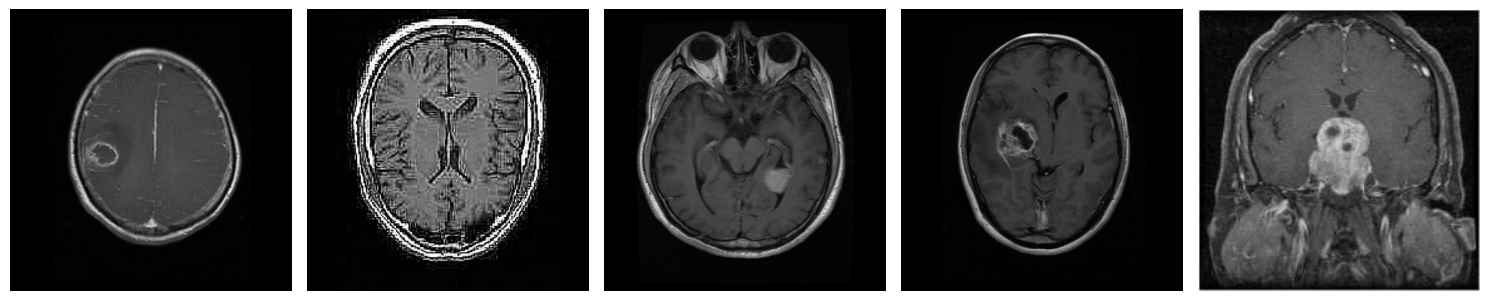

In [5]:
train_images_path = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/train'
image_files = os.listdir(train_images_path)
num_images_to_plot = 5
selected_images = random.sample(image_files, num_images_to_plot)

plt.figure(figsize=(15, 10))
for i, image_name in enumerate(selected_images):
    image_path = os.path.join(train_images_path, image_name)
    image = Image.open(image_path)

    plt.subplot(1, num_images_to_plot, i+1)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [7]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.annotations.iloc[idx, 1:].values.astype("int")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [8]:
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
train_dataset = CustomDataset(csv_file='/content/Labeled-MRI-Brain-Tumor-Dataset-1/train/_classes.csv',
                              root_dir='/content/Labeled-MRI-Brain-Tumor-Dataset-1/train',
                              transform=data_transforms)

valid_dataset = CustomDataset(csv_file='/content/Labeled-MRI-Brain-Tumor-Dataset-1/valid/_classes.csv',
                              root_dir='/content/Labeled-MRI-Brain-Tumor-Dataset-1/valid',
                              transform=data_transforms)

test_dataset = CustomDataset(csv_file='/content/Labeled-MRI-Brain-Tumor-Dataset-1/test/_classes.csv',
                             root_dir='/content/Labeled-MRI-Brain-Tumor-Dataset-1/test',
                             transform=data_transforms)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

In [11]:
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'test': len(test_dataset)
}

class_names = train_dataset.annotations.columns[1:].tolist()
num_classes = len(class_names)

print("Dataset Sizes:", dataset_sizes)
print("Class Names:", class_names)
print("Number of Classes:", num_classes)

Dataset Sizes: {'train': 1695, 'valid': 502, 'test': 246}
Class Names: [' Glioma', ' Meningioma', ' No Tumor', ' Pituitary']
Number of Classes: 4


In [12]:
# Define the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 59.9MB/s]


Epoch 0/9
----------
train Loss: 0.9354 Acc: 0.6507
valid Loss: 0.5371 Acc: 0.8486

Epoch 1/9
----------
train Loss: 0.6745 Acc: 0.7617
valid Loss: 0.3850 Acc: 0.8625

Epoch 2/9
----------
train Loss: 0.5889 Acc: 0.7935
valid Loss: 0.4933 Acc: 0.8466

Epoch 3/9
----------
train Loss: 0.5189 Acc: 0.8289
valid Loss: 0.3880 Acc: 0.8924

Epoch 4/9
----------
train Loss: 0.4514 Acc: 0.8472
valid Loss: 0.4592 Acc: 0.8785

Epoch 5/9
----------
train Loss: 0.3893 Acc: 0.8726
valid Loss: 0.3068 Acc: 0.9084

Epoch 6/9
----------
train Loss: 0.3972 Acc: 0.8732
valid Loss: 0.2545 Acc: 0.9323

Epoch 7/9
----------
train Loss: 0.2882 Acc: 0.9056
valid Loss: 0.2167 Acc: 0.9283

Epoch 8/9
----------
train Loss: 0.2326 Acc: 0.9280
valid Loss: 0.1743 Acc: 0.9482

Epoch 9/9
----------
train Loss: 0.1996 Acc: 0.9351
valid Loss: 0.1846 Acc: 0.9402

Training complete in 4m 57s
Best val Acc: 0.948207
Test Accuracy: 0.9228
Precision: 0.9221
Recall: 0.9228
F1 Score: 0.9219


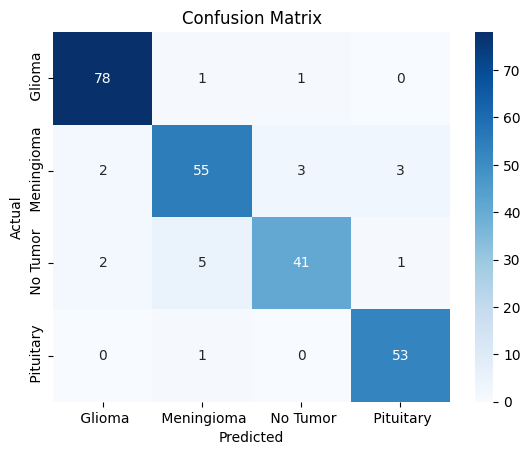

In [13]:

# Training and validation function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            dataloader = train_loader if phase == 'train' else valid_loader
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.max(1)[1])

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.max(1)[1])

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()   # Set model to evaluate mode
    running_corrects = 0
    all_preds = []
    all_labels = []

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data.max(1)[1])
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.data.max(1)[1].cpu().numpy())

    accuracy = running_corrects.double() / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(accuracy))

    # Calculate precision, recall, f1-score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1 Score: {:.4f}'.format(f1))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model
evaluate_model(model, test_loader)

In [14]:
torch.save(model.state_dict(), 'resnet50_model.pth')


In [15]:
def test_model(model, dataloader):
    model.eval()
    corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.argmax(dim=1))

    test_acc = corrects.double() / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))

# Test the model on the test set
test_model(model, test_loader)

Test Accuracy: 0.9309


In [19]:
# Define the transformations for preprocessing the image
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the model architecture without pretrained weights
model = models.resnet50()

# Modify the last fully connected layer to match the number of classes in your dataset
num_classes = 4
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)

# Load the state dictionary of the trained model
model_path = '/content/resnet50_model.pth'
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()

# Function to classify an image
def classify_image(image_path, model, transform):
    # Open the image
    image = Image.open(image_path)
    # Apply transformations
    image = transform(image).unsqueeze(0)  # Add batch dimension
    # Perform inference
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
    return predicted_class

# Path to the image you want to classify
image_path = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/train/Tr-no_0016_jpg.rf.cdf780eb3e921d6fb86ff2ee6b00c800.jpg'  # Update with the path to your image

# Perform classification
predicted_class = classify_image(image_path, model, data_transform)
print("Predicted Class Index:", predicted_class)

Predicted Class Index: 2


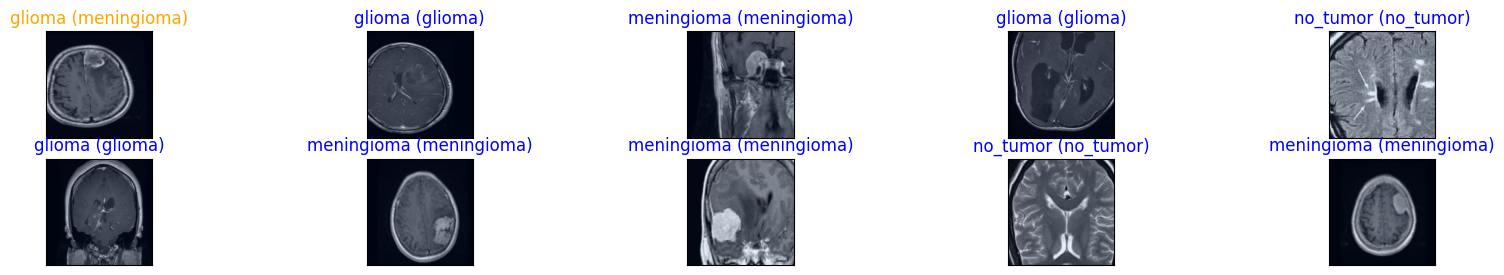

In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# Ensure your model is in evaluation mode
model.eval()

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define text labels
target_labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# To collect the results
x_test = []
y_test = []
y_hat = []

# Iterate over the test data
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        x_test.append(images.cpu())
        y_test.append(labels)
        y_hat.append(outputs.cpu())

# Concatenate results
x_test = torch.cat(x_test)
y_test = torch.cat(y_test)
y_hat = torch.cat(y_hat)

# Convert predictions to numpy if needed
y_hat = y_hat.numpy()

# Plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(len(x_test), size=10, replace=False)):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])

    # Get the image and normalize it to [0, 1]
    image = np.squeeze(x_test[idx].numpy().transpose(1, 2, 0))  # Transpose if needed
    image = (image - image.min()) / (image.max() - image.min())

    ax.imshow(image, cmap='gray')  # Use 'gray' cmap for MRI images

    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx].numpy())  # Assuming y_test contains one-hot encoded labels

    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color="blue" if pred_idx == true_idx else "orange")
plt.show()
